This code uses built-in functions from the Image class in PIL to execute isometries on a given image. It snapshots the lens view after each isometry, then puts those images into a numpy array. It then calculates the persistent homology of the data. For different images, 'lens_sz' and 'intervals' should be adjusted.

## imports

In [1]:
# Imports
import numpy as np
import math

# For image and video manipulation
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import PIL
import glob


# Persistent homology
from ripser import ripser
from persim import plot_diagrams
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
%matplotlib inline

# New imports spring study
import gudhi as gd
import imp
import DVR

C:\Users\dinko\AppData\Local\Temp\ipykernel_4196\4123536121.py:24: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
# Grab image from files
img_names = glob.glob('../images/*')
print(img_names)

img = Image.open(glob.glob('../images/C1med*')[0])
img = img.convert('L')

print(glob.glob('../images/C2arrow*')[0])
C2 = Image.open(glob.glob('../images/C2arrow*')[0])
C2 = C2.convert('L')

print(glob.glob('../images/C3arrow*')[0])
C3 = Image.open(glob.glob('../images/C3arrow*')[0])
C3 = C3.convert('L')

print(glob.glob('../images/C4arrow*')[0])
C4 = Image.open(glob.glob('../images/C4arrow*')[0])
C4 = C4.convert('L')

print(glob.glob('../images/C6arrow*')[0])
C6 = Image.open(glob.glob('../images/C6arrow*')[0])
C6 = C6.convert('L')

# img2 = Image.open(img_names[0])
# img2 = img.convert('L')
# img2 = img.resize((3809*3,1614*3), resample = PIL.Image.Resampling.BOX)


['../images\\C1 curly arrow.png', '../images\\C1 horsehex.png', '../images\\C1 horseshoe.png', '../images\\C1 spiral.png', '../images\\C1arrows.png', '../images\\C1bigarrows.png', '../images\\C1medarrows.png', '../images\\C2arrow.png', '../images\\C3 spiral.png', '../images\\C3arrows.png', '../images\\C4arrows.png', '../images\\C4pinwheel.png', '../images\\C6 snowflake.png', '../images\\C6 star.png', '../images\\C6arrows.png', '../images\\dataset', '../images\\david_tiling.png', '../images\\smallcheck.jpeg', '../images\\testPersis.png', '../images\\testPersisC2.png']
../images\C2arrow.png
../images\C3arrows.png
../images\C4arrows.png
../images\C6arrows.png


## function defs

In [3]:
# if you want to store generated images in a file
def store_snapshots(image_ls):
    counter = 0
    for img1 in image_ls:
        img1.save("images/dataset/"+str(counter)+".png")
        counter+=1

In [4]:
# see how many points are persisting
def persistingPoints(res,simpDim = 1):
    Hn = res['dgms'][simpDim].tolist() # all intervals in simpDim
    d = []
    for pair in Hn: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in Hn
    d.sort(reverse = True) # sorting from longest to shortest intervals
    print(d[:6])

translation_snapshot() translates the plane by a vector a and returns the lens view afterwards. It takes an image (Image), the lens size (int), and the translation vector (tuple) that shifts the plane in the direction of the vector. 

In [5]:
def translation_snapshot(img, lens_sz, a):
    (x,y)=a
    x=-x #since x and y will shift the crop and not the plane, need to make sure it is going in right direction
    (length, height) = img.size
    lens_corner_x=length/2.0 - lens_sz/2.0 +x
    lens_corner_y=height/2.0 - lens_sz/2.0 +y
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_sz, lens_corner_y+lens_sz))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_sz>length or lens_corner_y+lens_sz>height):
        print("I came off the page!")
        return False
    return ret_img

In [6]:
# fixed scan where every degree and translation gets turned into a point, d_num * t_num^2 isoms
def fixedIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    intervals_x = np.linspace((-1)*lens_range, lens_range, translation_num)
    intervals_y = np.linspace((-1)*lens_range, lens_range, translation_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for x in intervals_x:
            for y in intervals_y:
                if lens_crunch == False:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
                else:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                          math.ceil(lens_sz / crunch_kernel)),
                                                                                         resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))

    
    return image_list

In [7]:
# For each degree_num, do translation num, so d_num * t_num isoms
def transIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for j in range(translation_num):
            x = rng.integers((-1)*lens_range, lens_range)
            y = rng.integers((-1)*lens_range, lens_range)
            if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
            else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [8]:
# choose an insometry completely randomly from within a range; degree_num = number of random isos, translation does nothing
def randIso(img, lens_sz, degree_num, translation_num = 0, zero_translations = 0, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = rng.uniform(0.0,360.0, size = degree_num)
    j = 0
    
    for d in degrees:
        #print(j)
        j = j + 1
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    for k in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [12]:
def imgListToArray(img_list):
    data = []
    x=0
    for i in img_list:
        img_arr = np.asarray(i)
        data.append(img_arr.reshape(-1))
    data = np.array(data)
    return data

# persistence plots

## C1

In [13]:
imp.reload(DVR)

<module 'DVR' from 'C:\\Users\\dinko\\Documents\\persistent-symmetry\\studentDemos\\daleDemos\\DVR.py'>

Set k =  7


Text(0.5, 1.0, '')

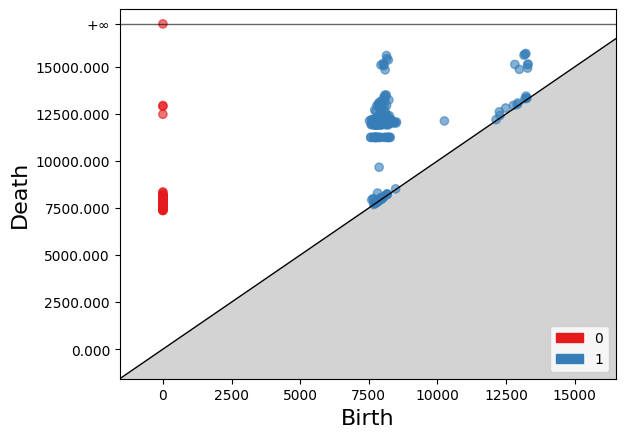

In [14]:
image_list = transIso(img, lens_sz = 300, degree_num = 60, translation_num = 3, zero_translations = 0)
data = imgListToArray(image_list)
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence()
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")
#looks like sample size is too small
#c1 image

[452.33203125, 338.669921875, 296.0, 274.966796875, 262.8046875, 260.46484375]


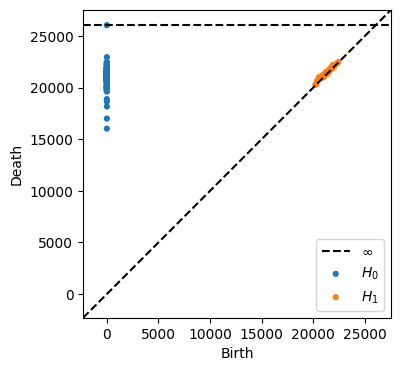

In [15]:
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

Set k =  7
[1094.568359375, 974.693359375, 899.82421875, 899.125, 898.796875, 813.33984375]


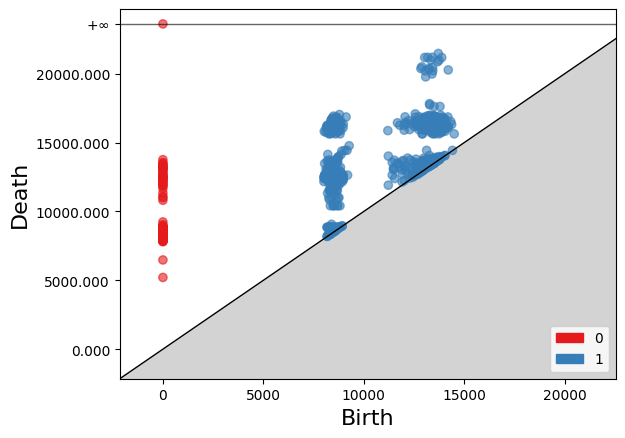

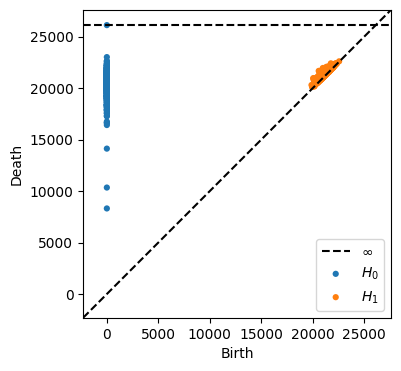

In [16]:
#c1 more isoms
image_list = transIso(img, lens_sz = 300, degree_num = 120, translation_num = 4, zero_translations = 50)
data = imgListToArray(image_list)
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence()
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)
# still too little sampling?
# will try decreasing lens size

Set k =  7
[526.09375, 524.8681640625, 507.685546875, 461.197265625, 447.5166015625, 441.8447265625]


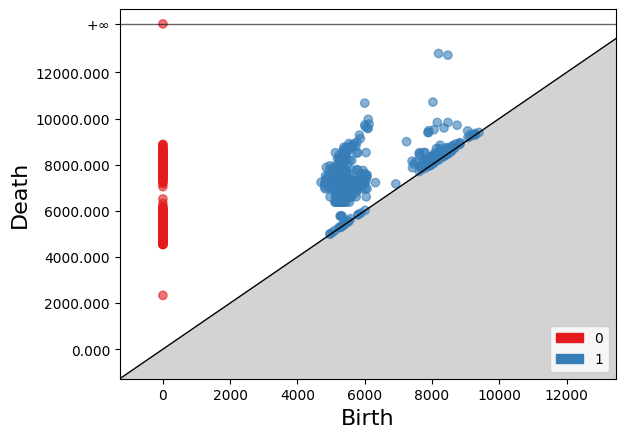

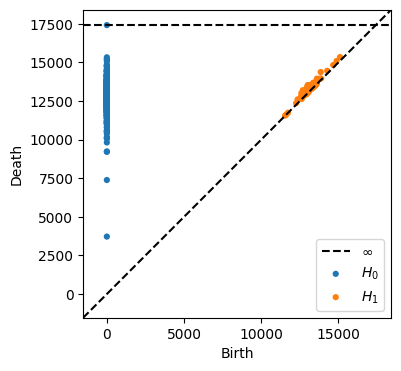

In [17]:
#c1
image_list = transIso(img, lens_sz = 200, degree_num = 120, translation_num = 4, zero_translations = 50)
data = imgListToArray(image_list)
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence()
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)
# this looks better! we are expecting 3 persistent cycles and only seeing 2 though.

Set k =  7
[526.09375, 524.8681640625, 507.685546875, 461.197265625, 447.5166015625, 441.8447265625]


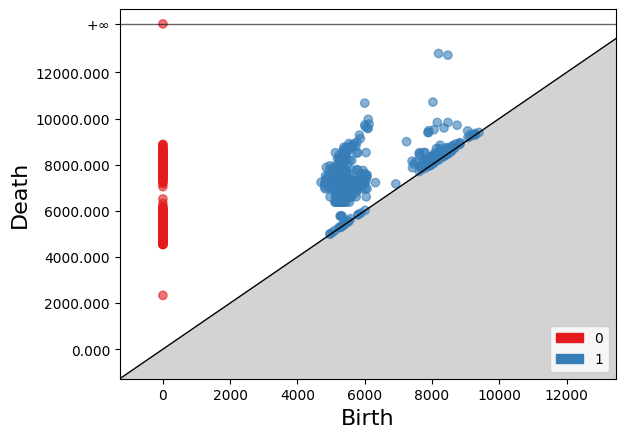

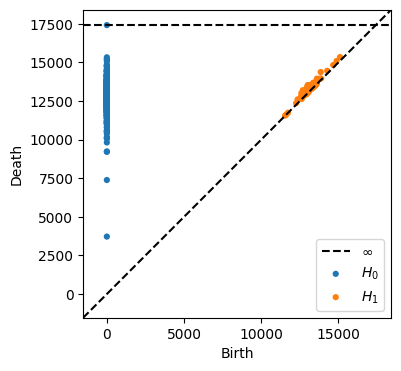

In [18]:
#c1
#coeff = 2 now for DVR homology
image_list = transIso(img, lens_sz = 200, degree_num = 120, translation_num = 4, zero_translations = 50)
data = imgListToArray(image_list)
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 2)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms) 
# changing the field didn't change the result, which is expected for C1

Set k =  7
[910.2734375, 544.927734375, 478.5009765625, 477.2802734375, 472.578125, 447.2578125]


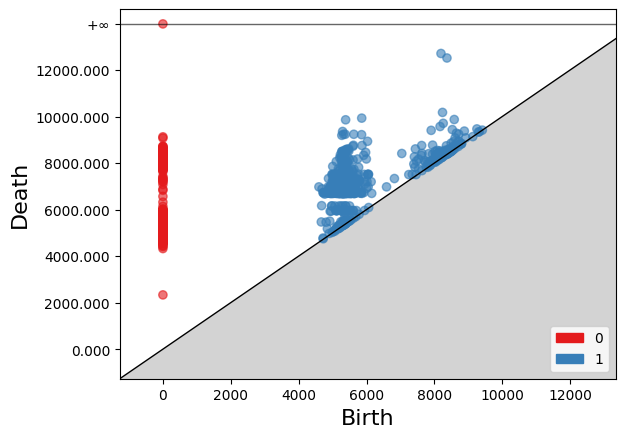

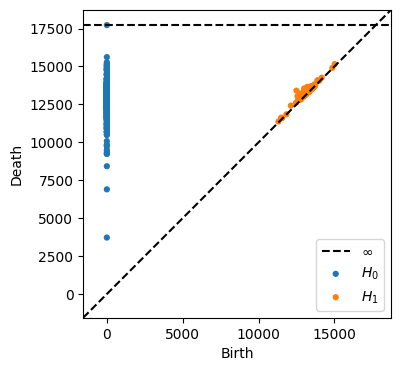

In [20]:
#c1
#trying to increase translations to see how that will change persistence
image_list = transIso(img, lens_sz = 200, degree_num = 60, translation_num = 8, zero_translations = 50)
data = imgListToArray(image_list)
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 2)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)
# it seems like the two most persitent points, which would corespond to the x and y translations, grew more persistent,
# while the point that might correspond to the rotational axis grew less persistent, which aligns with expectations.

Set k =  8


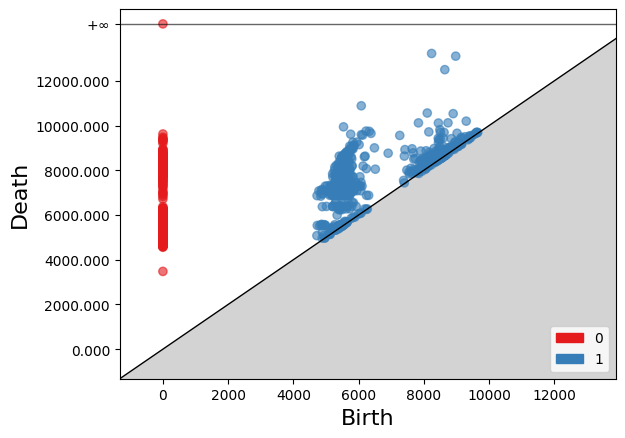

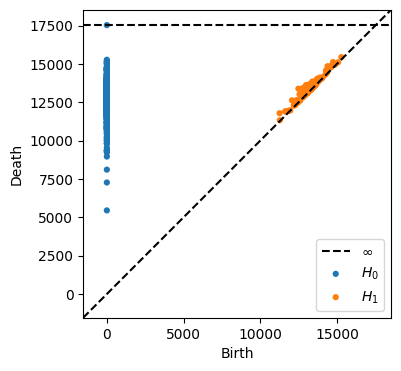

In [21]:
#c1
#trying to increase rotations to see how that will change persistence
image_list = transIso(img, lens_sz = 200, degree_num = 360, translation_num = 2, zero_translations = 50)
data = imgListToArray(image_list)
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 2)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)
# 3 signifigantly more persistent points!

Set k =  8


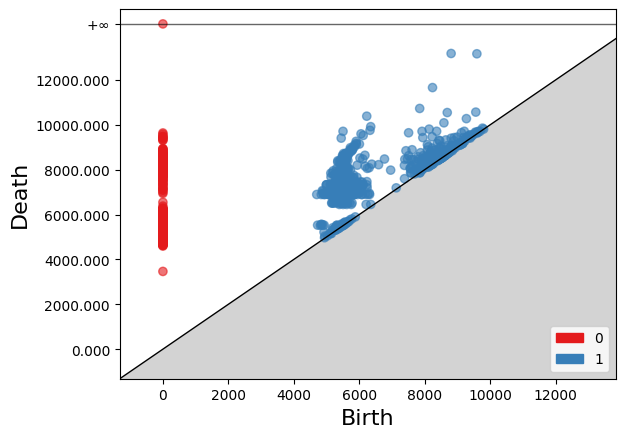

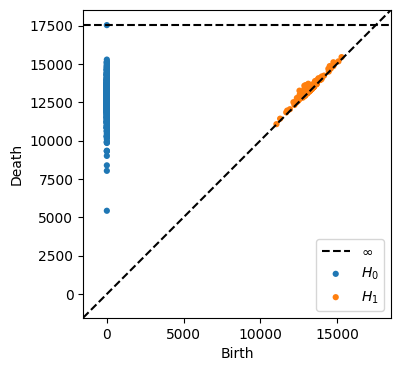

In [22]:
#c1
#increasing rotations even more
image_list = transIso(img, lens_sz = 200, degree_num = 720, translation_num = 1, zero_translations = 50)
data = imgListToArray(image_list)
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 2)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)
# perhaps too few translations

Set k =  8


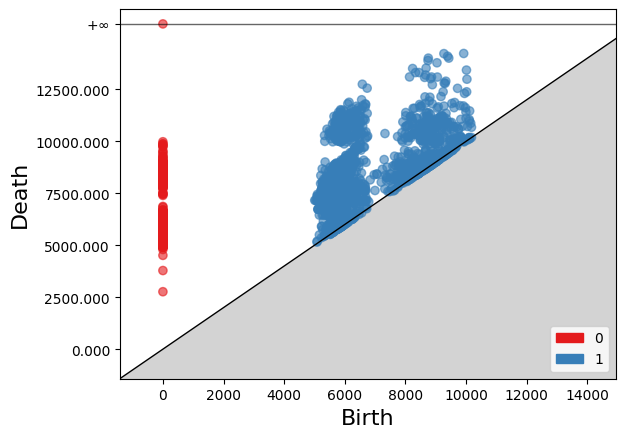

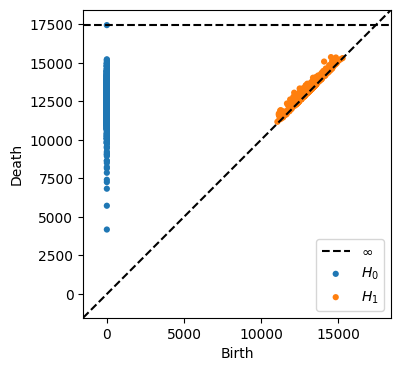

In [23]:
#c1
#increasing rotations even more
image_list = transIso(img, lens_sz = 200, degree_num = 720, translation_num = 2, zero_translations = 0)
data = imgListToArray(image_list)
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 2)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)
# note I also took zero_translations away, which are translations without rotation
# this took 20 minutes to run and produced poor results, too many rotations or too few translations?

Set k =  8


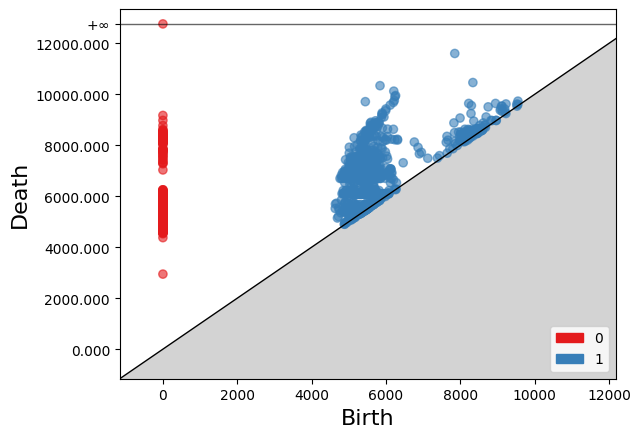

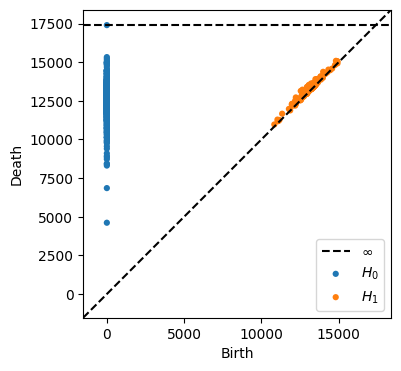

In [24]:
#c1
#random isometries this time
image_list = randIso(img, lens_sz = 200, degree_num = 720, translation_num = 0, zero_translations = 50)
data = imgListToArray(image_list)
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 2)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)
# doesn't seem to work well

Set k =  8


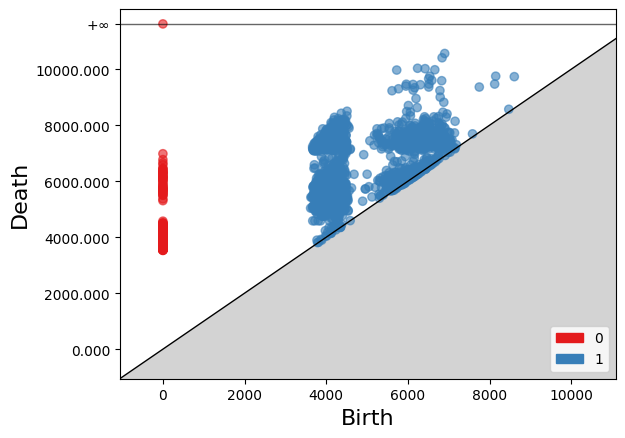

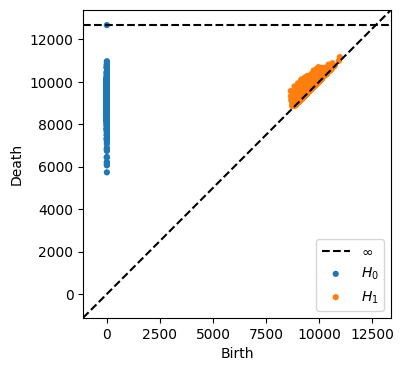

In [10]:
#c1
#fixed isometries this time
image_list = fixedIso(img, lens_sz = 150, degree_num = 180, translation_num = 2, zero_translations = 10)
data = imgListToArray(image_list)
geo_cpx = DVR.DVR(3, points = data, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 2)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)
# unimpressive again

# C2 through C6

Set k =  8


Text(0.5, 1.0, '')

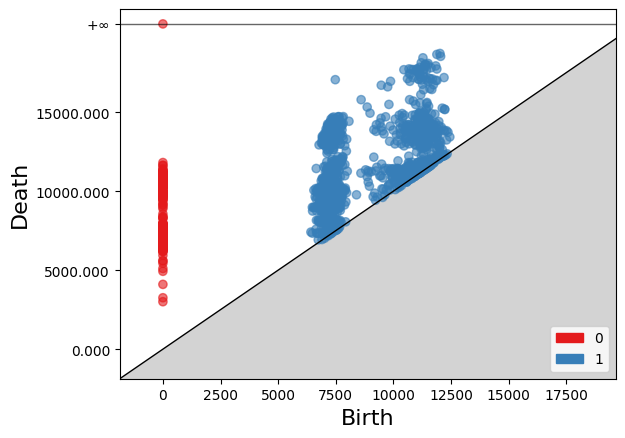

In [13]:
#using the most successful parameters from the C1 test, this time for both Z/Z2 and Z/Z3
imp.reload(DVR)
image_list22 = transIso(C2, lens_sz = 200, degree_num = 360, translation_num = 2, zero_translations = 50)
data22 = imgListToArray(image_list22)
geo_cpx = DVR.DVR(3, points = data22, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 2)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")

Set k =  8


Text(0.5, 1.0, '')

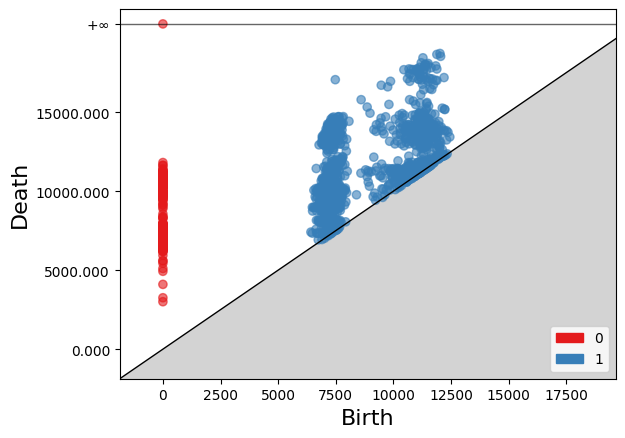

In [14]:
# C2 mod 3
image_list2 = transIso(C2, lens_sz = 200, degree_num = 360, translation_num = 2, zero_translations = 50)
data2 = imgListToArray(image_list2)
geo_cpx = DVR.DVR(3, points = data2, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 3)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")

Set k =  8


Text(0.5, 1.0, '')

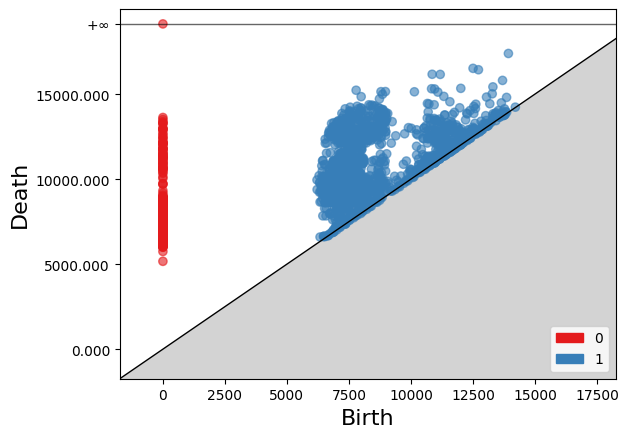

In [15]:
# C3 mod 2
image_list33 = transIso(C3, lens_sz = 200, degree_num = 360, translation_num = 2, zero_translations = 50)
data33 = imgListToArray(image_list33)
geo_cpx = DVR.DVR(3, points = data33, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 3)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")

Set k =  8


Text(0.5, 1.0, '')

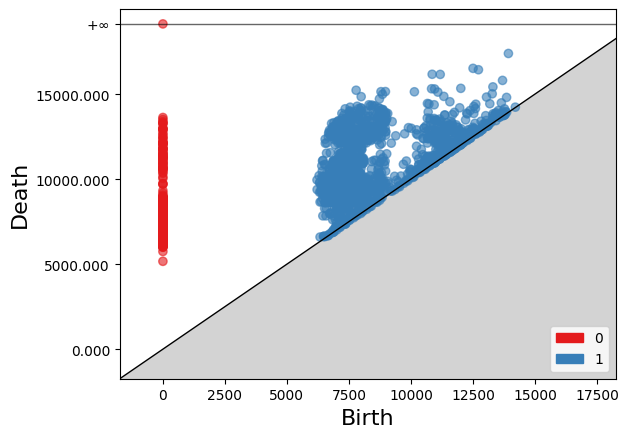

In [16]:
# C3 mod 3
image_list3 = transIso(C3, lens_sz = 200, degree_num = 360, translation_num = 2, zero_translations = 50)
data3 = imgListToArray(image_list3)
geo_cpx = DVR.DVR(3, points = data3, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 3)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")

Set k =  8


Text(0.5, 1.0, '')

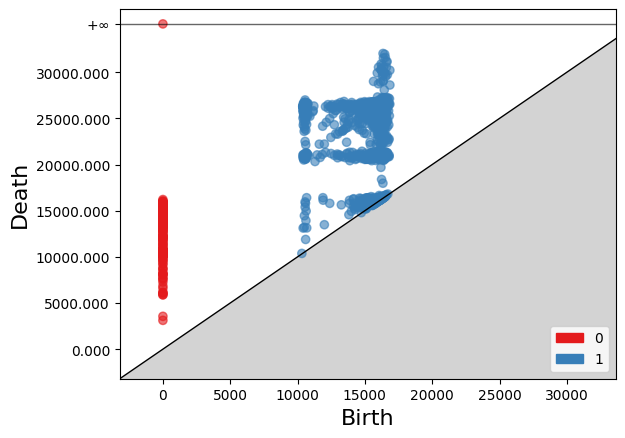

In [17]:
# C4 mod 2
image_list4 = transIso(C4, lens_sz = 200, degree_num = 360, translation_num = 2, zero_translations = 50)
data4 = imgListToArray(image_list4)
geo_cpx = DVR.DVR(3, points = data4, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 2)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")

Set k =  8


Text(0.5, 1.0, '')

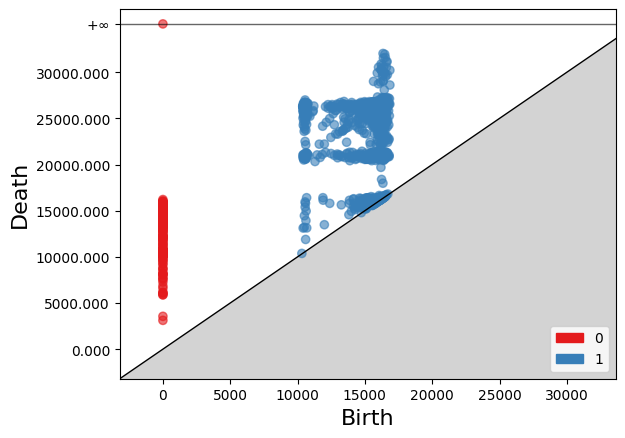

In [18]:
# C4 mod 3
image_list44 = transIso(C4, lens_sz = 200, degree_num = 360, translation_num = 2, zero_translations = 50)
data44 = imgListToArray(image_list44)
geo_cpx = DVR.DVR(3, points = data44, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 3)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")

Set k =  8


Text(0.5, 1.0, '')

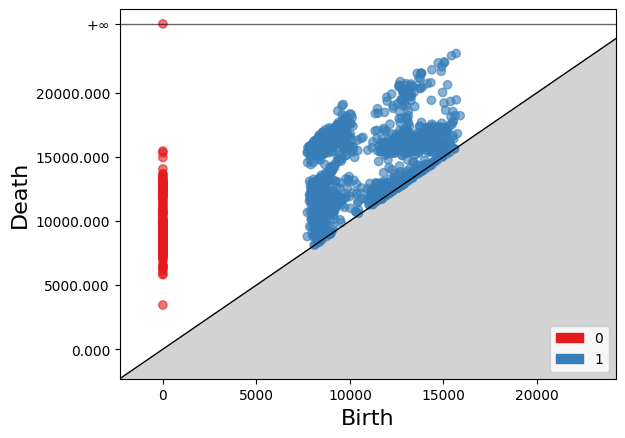

In [19]:
# C6 mod 2
image_list6 = transIso(C6, lens_sz = 200, degree_num = 360, translation_num = 2, zero_translations = 50)
data6 = imgListToArray(image_list6)
geo_cpx = DVR.DVR(3, points = data6, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 2)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")

Set k =  8


Text(0.5, 1.0, '')

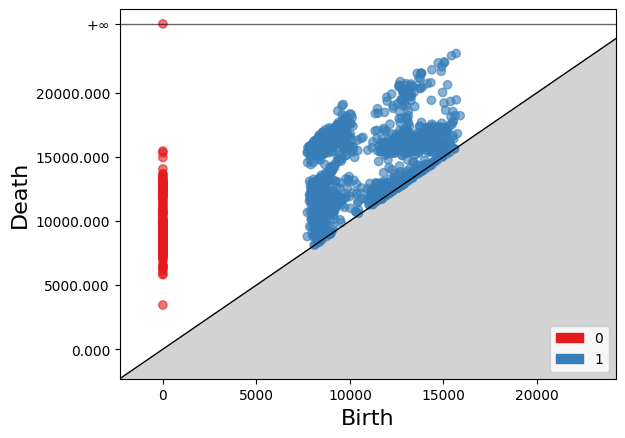

In [20]:
# C6 mod 3
image_list66 = transIso(C6, lens_sz = 200, degree_num = 360, translation_num = 2, zero_translations = 50)
data66 = imgListToArray(image_list66)
geo_cpx = DVR.DVR(3, points = data66, max_dimension = 2)
geo_ph = geo_cpx.persistence(homology_coeff_field = 3)
gd.plot_persistence_diagram(persistence = geo_ph, legend = True)
plt.title("")

These all are poor, perhaps could work with tuning. The difference in the size of fundemental domain could change things.
Notably changing the field coefficent did not change the persistence diagram for any of them.

## extraneous

[102000.0, 85935.0, 75480.0, 72165.0, 61710.0, 61710.0]


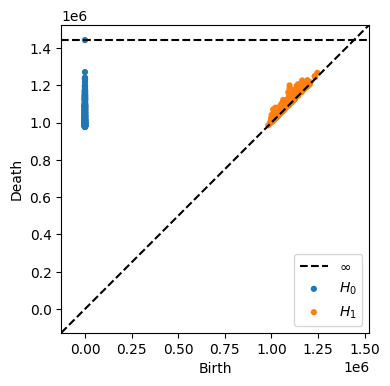

In [14]:
# This is an experiment using our best output (appearance of betty number 3) with n_perm.
image_list = fixedIso(img, lens_sz = 300, degree_num = 120, translation_num = 4, zero_translations = 50)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan", n_perm = 500)
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)